# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [1]:
from dotenv import load_dotenv
from env_utils import doublecheck_env

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env("example.env")

OPENAI_API_KEY=<not set>
LANGSMITH_API_KEY=****4abe
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ad-6


In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [3]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [4]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [5]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [ ]:
from langchain.agents import create_agent

agent = create_agent(
    model="ollama:gpt-oss:20b",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

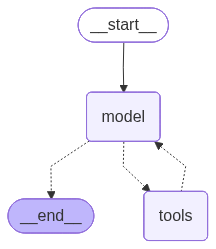

In [12]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [13]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (7d7d2a87-0bcb-48c1-b355-94348cbe3d6c)
 Call ID: 7d7d2a87-0bcb-48c1-b355-94348cbe3d6c
  Args:
    query: SELECT name, COUNT(*) as count FROM sqlite_master WHERE type='table' GROUP BY name ORDER BY count DESC LIMIT 1
================================= Tool Message =================================
Name: execute_sql

[('Track', 1)]
================================== Ai Message ==================================

The table with the largest number of entries is 'Track'.


In [14]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (1bcbca77-4a64-4bc9-a122-efaf36e0ccb3)
 Call ID: 1bcbca77-4a64-4bc9-a122-efaf36e0ccb3
  Args:
    query: SELECT genre, AVG(duration) FROM music WHERE duration != 0 GROUP BY genre LIMIT 5
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: music
[SQL: SELECT genre, AVG(duration) FROM music WHERE duration != 0 GROUP BY genre LIMIT 5]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================

It seems that the `music` table does not exist in the database. I will create a new query to find out which genres have tracks with the longest duration.

{"name": "execute_sql", "parameters

In [16]:
question = "Please list all of the tables?"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (10df9844-a45d-468b-8a5d-e6f5c65090e8)
 Call ID: 10df9844-a45d-468b-8a5d-e6f5c65090e8
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table'
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The tables in the database are:

1. Album
2. Artist
3. Customer
4. Employee
5. Genre
6. Invoice
7. InvoiceLine
8. MediaType
9. Playlist
10. PlaylistTrack
11. Track


**Create your own query here!**  Add some questions of your own.

In [17]:
question = "How many Artist are there?"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many Artist are there?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fd50c691-6ca2-4264-a676-446dede3533a)
 Call ID: fd50c691-6ca2-4264-a676-446dede3533a
  Args:
    query: SELECT COUNT(*) FROM Artists
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: Artists
[SQL: SELECT COUNT(*) FROM Artists]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================

The SQL query has a syntax error and the table 'Artists' does not exist in the database. 

Let me try again with the correct table name.

```sql
SELECT COUNT(*) FROM artists;
```

I will re-call the `execute_sql` tool with this new query: 

{"name": "execute_sql", "parameters": {"query":"SELECT COUNT(*) FROM arti

## Let's try this in the agent debugger!